# Imports

In [175]:
import numpy as np
import pandas as pd
from tabulate import tabulate

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris, load_digits, load_breast_cancer
from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score, rand_score

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.stats import mode
from scipy.optimize import linear_sum_assignment

plt.style.use('Solarize_Light2')

# Functions

## Normalization

In [176]:
def normalization(model, data) -> pd.DataFrame:
    # apply normalization techniques
    norm = model.fit_transform(data)
    return pd.DataFrame(data=norm, columns=data.columns)

## Map Clusters

In [177]:
def map_clusters_to_labels(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for cluster in np.unique(y_pred):
        mask = y_pred == cluster
        labels[mask] = mode(y_true[mask], keepdims=True).mode[0]
    return labels

In [178]:
def reorder_confusion_matrix(cm):
    # Hungarian algorithm minimizes cost, so we negate to maximize diagonal
    row_ind, col_ind = linear_sum_assignment(-cm)

    # Reorder columns based on optimal assignment
    reordered_cm = cm[:, col_ind]
    return reordered_cm

## Confusion Matrix

In [179]:
def heatmap(cm_k_means, cm_db_scan, k):
    # Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Width increases for better spacing

    # First subplot: K-Means
    sns.heatmap(cm_k_means, annot=True, fmt='d', cmap='RdPu', ax=axes[0])
    axes[0].set_xlabel('Predicted Cluster')
    axes[0].set_ylabel('True Cluster')
    axes[0].set_title('K-Means')

    # Second subplot: DBScan
    sns.heatmap(cm_db_scan[:k + 1, :], annot=True, fmt='d', cmap='RdPu', ax=axes[1])
    axes[1].set_xlabel('Predicted Cluster')
    axes[1].set_ylabel('True Cluster')
    axes[1].set_title('DB-Scan')

    plt.tight_layout()
    plt.show()

In [180]:
def confusion_matrix_heatmap(k_means_preds, y_true, db_scan_preds, y_true_db_scan, k):
  # Build confusion matrix
  cm_k_means = confusion_matrix(y_true, k_means_preds)
  cm_db_scan = confusion_matrix(y_true_db_scan, db_scan_preds)

  heatmap(cm_k_means, cm_db_scan, k)

  return (cm_k_means, cm_db_scan)

## Metrics

In [181]:
def calculate_accuracy(confusion_matrix) -> float:
    """
    Calculate accuracy from the confusion matrix.
    Accuracy is the ratio of correct predictions to total samples.

    Args:
    confusion_matrix (np.array): The confusion matrix.

    Returns:
    float: Accuracy value.
    """
    # Total correct predictions are the sum of the diagonal elements
    correct_predictions = np.trace(confusion_matrix)

    # Total samples is the sum of all elements in the confusion matrix
    total_samples = np.sum(confusion_matrix)

    # Calculate accuracy
    accuracy = correct_predictions / total_samples
    return accuracy

### Cal and Show

In [182]:
def cal_f1_score(confusion_mat):
    prf1 = []
    cm = np.array(confusion_mat)
    for i in range(cm.shape[0]):
        row_sum = np.sum(cm[i, :])
        col_sum = np.sum(cm[:, i])

        if row_sum == 0 or col_sum == 0:
            prf1.append([0, 0, 0])
            continue

        recall = cm[i, i] / row_sum
        precision = cm[i, i] / col_sum

        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * recall * precision / (precision + recall)

        prf1.append(np.array([precision, recall, f1]))

    return np.array(prf1)

In [183]:
def metrics_table(method_name, prf_array, accuracy, w_precision, w_recall, w_f1):
    rows = []

    for i, (p, r, f1) in enumerate(prf_array):
        rows.append([method_name, i, f"{p:.2f}", f"{r:.2f}", f"{f1:.2f}", ""])

    # Summary row with weighted metrics
    rows.append([
        method_name, "Overall",
        f"{w_precision:.3f}", f"{w_recall:.3f}", f"{w_f1:.3f}", f"{accuracy:.2%}"
    ])

    print(tabulate(
        rows,
        headers=["Method", "Cluster", "Precision", "Recall", "F1 Score", "Accuracy"],
        tablefmt="grid"
    ))


In [184]:
def calculate_metrics(cm_kmeans, cm_dbscan):
    # Accuracy
    acc_kmeans = calculate_accuracy(cm_kmeans)
    acc_dbscan = calculate_accuracy(cm_dbscan)

    # Precision, recall, F1
    prf_kmeans = np.array(cal_f1_score(cm_kmeans))
    prf_dbscan = np.array(cal_f1_score(cm_dbscan))

    # Weighted Precision, recall, F1
    weights_k = np.sum(cm_kmeans, axis=1)
    weights_d = np.sum(cm_dbscan, axis=1)

    # Weighted Precision, Recall, F1 for K-Means
    wp_k = np.sum(prf_kmeans[:, 0] * weights_k) / np.sum(weights_k)
    wr_k = np.sum(prf_kmeans[:, 1] * weights_k) / np.sum(weights_k)
    wf1_k = np.sum(prf_kmeans[:, 2] * weights_k) / np.sum(weights_k)

    # Weighted Precision, Recall, F1 for DBSCAN
    wp_d = np.sum(prf_dbscan[:, 0] * weights_d) / np.sum(weights_d)
    wr_d = np.sum(prf_dbscan[:, 1] * weights_d) / np.sum(weights_d)
    wf1_d = np.sum(prf_dbscan[:, 2] * weights_d) / np.sum(weights_d)

    metrics_table("K-Means", prf_kmeans, acc_kmeans, wp_k, wr_k, wf1_k)
    print("\n\n")
    metrics_table("DBSCAN", prf_dbscan, acc_dbscan, wp_d, wr_d, wf1_d)

# Main

In [190]:
def main(X: pd.DataFrame, y_true: np.array, k: int, eps: float):
    # Normalize X
    X_norm = normalization(MinMaxScaler(), X)

    # Perform KMeans and DBScan clustering
    kmeans = KMeans(n_clusters=k)
    y_pred_k_means = kmeans.fit_predict(X_norm)

    dbscan = DBSCAN(eps=eps)
    y_pred_db_scan = dbscan.fit_predict(X_norm)

    # new versions of y_preds
    k_means_labels = map_clusters_to_labels(y_true, y_pred_k_means)

    # remove noises
    dbscan_core_pred = y_pred_db_scan[y_pred_db_scan != -1]
    dbscan_core_true = y_true[y_pred_db_scan != -1]

    db_scan_labels = map_clusters_to_labels(dbscan_core_true, dbscan_core_pred)

    # map clusters and create confusion matrix
    _ = confusion_matrix_heatmap(y_pred_k_means, y_true, y_pred_db_scan, y_true, k)
    cm_k_means, cm_db_scan = confusion_matrix_heatmap(k_means_labels, y_true, db_scan_labels, dbscan_core_true, k)

    calculate_metrics(cm_k_means, cm_db_scan)

# Load Dataset and Run Main

## Iris

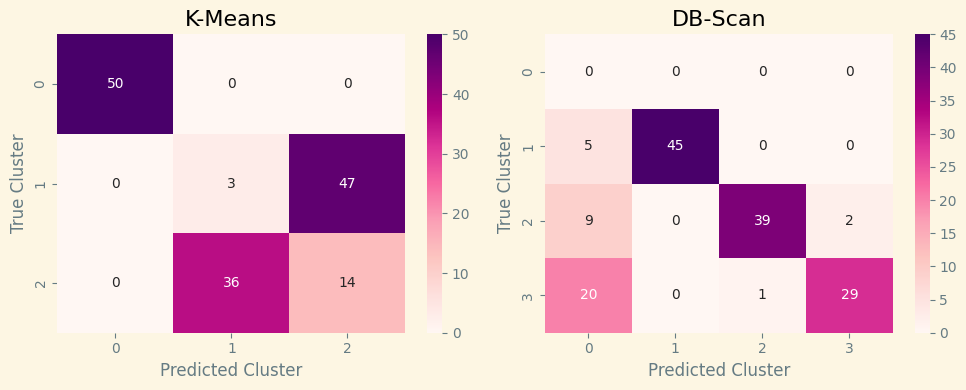

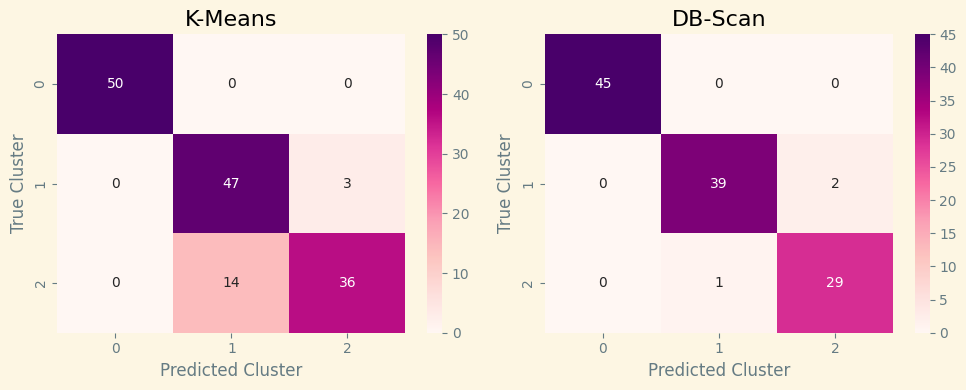

+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| K-Means  | 0         |       1     |    1     |      1     |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 1         |       0.77  |    0.94  |      0.85  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 2         |       0.92  |    0.72  |      0.81  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | Overall   |       0.898 |    0.887 |      0.885 | 88.67%     |
+----------+-----------+-------------+----------+------------+------------+



+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+========

In [191]:
X1, y1 = load_iris(return_X_y=True, as_frame=True)

main(X=X1, y_true=y1.to_numpy(), k=len(np.unique(y1)), eps=0.128)

## Breast Cancer

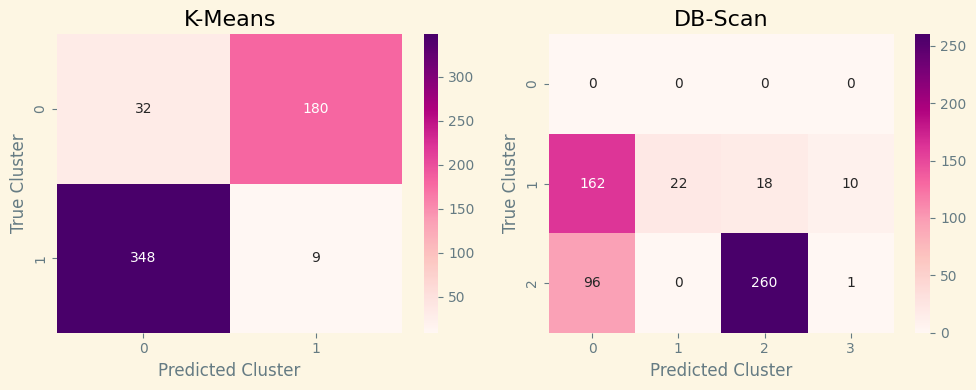

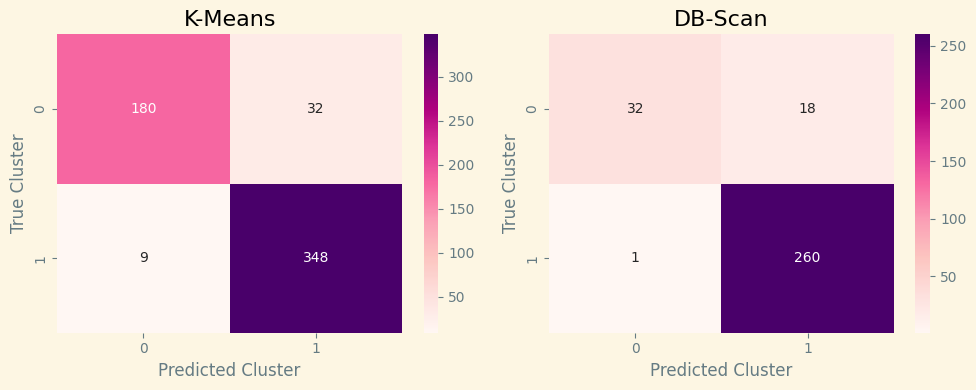

+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| K-Means  | 0         |       0.95  |    0.85  |      0.9   |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 1         |       0.92  |    0.97  |      0.94  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | Overall   |       0.929 |    0.928 |      0.927 | 92.79%     |
+----------+-----------+-------------+----------+------------+------------+



+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| DBSCAN   | 0         |       0.97  |    0.64  |      0.77  |            |
+--------

In [192]:
X1, y1 = load_breast_cancer(return_X_y=True, as_frame=True)

main(X=X1, y_true=y1.to_numpy(), k=len(np.unique(y1)), eps=0.325)

# Digits

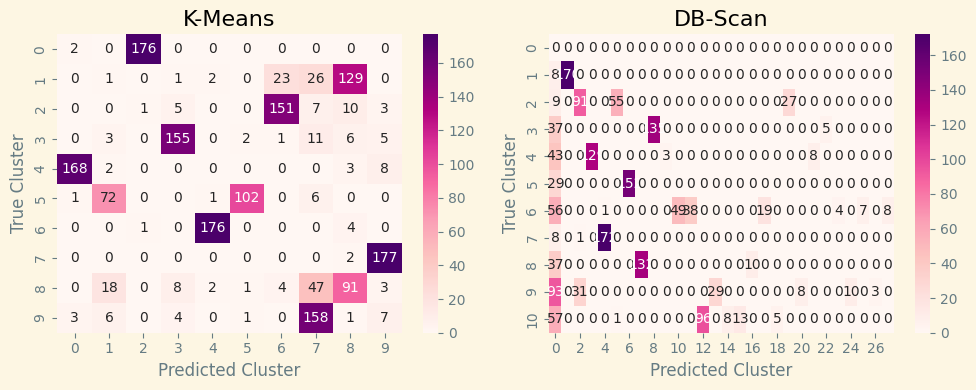

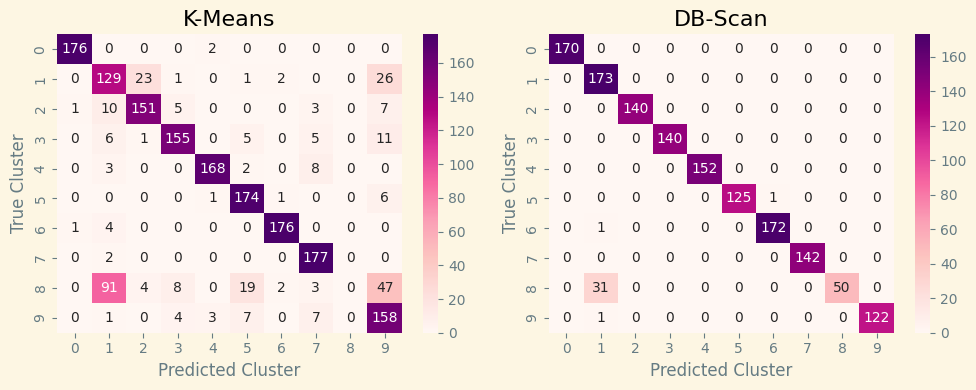

+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| K-Means  | 0         |       0.99  |    0.99  |       0.99 |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 1         |       0.52  |    0.71  |       0.6  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 2         |       0.84  |    0.85  |       0.85 |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 3         |       0.9   |    0.85  |       0.87 |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 4         |       0.97  |    0.93  |       0.95 |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  |

In [195]:
X1, y1 = load_digits(return_X_y=True, as_frame=True)

main(X=X1, y_true=y1.to_numpy(), k=len(np.unique(y1)), eps=1.3)